

Quelle: https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_205_c__custom_16541269/default/table?lang=en
Bookmark: https://ec.europa.eu/eurostat/databrowser/bookmark/559ab32e-cd0e-4893-b331-500eb0ae974b?lang=en


In [94]:
import pandas as pd
import os

# Input- und Output-Pfade
EUROSTAT_FILE = "in/prices/estat_nrg_pc_205_c_filtered_en.csv"
PLOT_OUT_DIR = "out/price/eurostat_components"
EXCEL_OUTPUT = "out/price/eurostat_electricity_prices_components.xlsx"

os.makedirs(PLOT_OUT_DIR, exist_ok=True)

In [95]:
# CSV einlesen
df_eurostat_raw = pd.read_csv(EUROSTAT_FILE, delimiter=",", encoding="utf-8")

# Relevante Spalten auswählen
df_eurostat_cleaned = df_eurostat_raw[[
    "TIME_PERIOD",
    "nrg_prc",  
    "Components of energy prices",  
    # "nrg_cons",  # Band kürzel
    # "Energy consumption",  # Bandbeschreibung
    "OBS_VALUE"
]].copy()

# NaNs in OBS_VALUE filtern und in float umwandeln
df_eurostat_cleaned = df_eurostat_cleaned.dropna(subset=["OBS_VALUE"])
df_eurostat_cleaned["OBS_VALUE"] = pd.to_numeric(df_eurostat_cleaned["OBS_VALUE"], errors="coerce")
df_eurostat_cleaned = df_eurostat_cleaned.dropna(subset=["OBS_VALUE"])


# df_eurostat_cleaned[df_eurostat_cleaned["Components of energy prices"] =="Taxes, fees, levies and charges"]
df_eurostat_cleaned

,TIME_PERIOD,nrg_prc,Components of energy prices,OBS_VALUE
0,2024,ALLOW_OTH,Other allowance,0.0000
1,2017,NETC,Network costs,0.0229
2,2018,NETC,Network costs,0.0184
3,2019,NETC,Network costs,0.0204
4,2020,NETC,Network costs,0.0244
...,...,...,...,...
57,2020,VAT,Value added tax (VAT),0.0239
58,2021,VAT,Value added tax (VAT),0.0273
59,2022,VAT,Value added tax (VAT),0.0375
60,2023,VAT,Value added tax (VAT),0.0373


In [96]:
# Überblick über die wichtigsten Eigenschaften des Datensatzes


# Anzahl Zeilen und Spalten
print(f"Zeilen: {len(df_eurostat_cleaned)}")
print(f"Spalten: {list(df_eurostat_cleaned.columns)}\n")

unique_years = df_eurostat_cleaned['TIME_PERIOD'].unique()
print(f"TIME_PERIODs: {sorted(unique_years)}")

unique_components = df_eurostat_cleaned['Components of energy prices'].unique()
print(f"\n Komponenten von Energiepreisen: {unique_components}")

print("\n📊 Anzahl Beobachtungen pro Komponente:")
print(df_eurostat_cleaned['Components of energy prices'].value_counts())


zero_value_components = (
    df_eurostat_cleaned
    .groupby('Components of energy prices')['OBS_VALUE']
    .apply(lambda x: (x == 0).all())
)

COMPONENTS_ALL_ZERO = zero_value_components[zero_value_components].index.tolist()
print(f"\nKomponenten mit nur 0 Einträge: {COMPONENTS_ALL_ZERO}")


Zeilen: 62
Spalten: ['TIME_PERIOD', 'nrg_prc', 'Components of energy prices', 'OBS_VALUE']

TIME_PERIODs: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

 Komponenten von Energiepreisen: ['Other allowance' 'Network costs' 'Energy and supply' 'Other'
 'Capacity taxes' 'Capacity taxes allowances' 'Environmental taxes'
 'Environmental taxes allowance' 'Taxes, fees, levies and charges'
 'Taxes, fees, levies and charges allowance' 'Nuclear taxes'
 'Nuclear taxes allowance' 'Renewable taxes' 'Renewable taxes allowance'
 'Value added tax (VAT)']

📊 Anzahl Beobachtungen pro Komponente:
Components of energy prices
Network costs                                8
Energy and supply                            8
Other                                        6
Capacity taxes                               6
Environmental taxes                          6
Taxes, fees, levies and charges              6
Renewable taxes                              6
Value added tax (VAT)                        6
Nuclear t

In [97]:

# Komponenten, die Daten enthalten
valid_components = df_eurostat_cleaned[
    ~df_eurostat_cleaned["Components of energy prices"].isin(COMPONENTS_ALL_ZERO)
]["Components of energy prices"].unique()


df_prophet_all = (
    df_eurostat_cleaned[
        df_eurostat_cleaned["Components of energy prices"].isin(valid_components)
    ]
    .copy()
)

df_prophet_all["ds"] = pd.to_datetime(df_prophet_all["TIME_PERIOD"], format="%Y")
df_prophet_all["y"] = df_prophet_all["OBS_VALUE"]
df_prophet_all["component"] = df_prophet_all["Components of energy prices"]


df_prophet_all = df_prophet_all[["ds", "y", "component"]].sort_values(["component", "ds"]).reset_index(drop=True)

df_prophet_all.head(10)


,ds,y,component
0,2019-01-01,0.0040,Capacity taxes
1,2020-01-01,0.0050,Capacity taxes
2,2021-01-01,0.0047,Capacity taxes
3,2022-01-01,0.0057,Capacity taxes
4,2023-01-01,0.0074,Capacity taxes
5,2024-01-01,0.0066,Capacity taxes
6,2017-01-01,0.0230,Energy and supply
7,2018-01-01,0.0332,Energy and supply
8,2019-01-01,0.0309,Energy and supply
9,2020-01-01,0.0322,Energy and supply


In [98]:
from prophet import Prophet

# Zieljahre als DataFrame
future_years = [2025, 2030, 2035, 2040, 2045, 2050]
future_df = pd.DataFrame({"ds": pd.to_datetime(future_years, format="%Y")})

# Liste für alle Prognosen
all_forecasts = []

# Iteration über jede gültige Komponente
for component in df_prophet_all["component"].unique():
    df_component = df_prophet_all[df_prophet_all["component"] == component][["ds", "y"]].copy()
    
    # Prophet-Modell erstellen und trainieren
    model = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
    model.fit(df_component)
    
    # Vorhersage für zukünftige Jahre
    forecast = model.predict(future_df)
    
    # Relevante Spalten extrahieren und Komponente zuordnen
    forecast_result = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].copy()
    forecast_result["component"] = component
    all_forecasts.append(forecast_result)

# Alle Ergebnisse zu einem DataFrame zusammenführen
df_forecast_all = pd.concat(all_forecasts).sort_values(["component", "ds"]).reset_index(drop=True)

df_forecast_all

20:13:07 - cmdstanpy - INFO - Chain [1] start processing
20:13:07 - cmdstanpy - INFO - Chain [1] done processing
20:13:07 - cmdstanpy - INFO - Chain [1] start processing
20:13:07 - cmdstanpy - INFO - Chain [1] done processing
20:13:07 - cmdstanpy - INFO - Chain [1] start processing
20:13:07 - cmdstanpy - INFO - Chain [1] done processing
20:13:08 - cmdstanpy - INFO - Chain [1] start processing
20:13:08 - cmdstanpy - INFO - Chain [1] done processing
20:13:08 - cmdstanpy - INFO - Chain [1] start processing
20:13:08 - cmdstanpy - INFO - Chain [1] done processing
20:13:08 - cmdstanpy - INFO - Chain [1] start processing
20:13:08 - cmdstanpy - INFO - Chain [1] done processing
20:13:08 - cmdstanpy - INFO - Chain [1] start processing
20:13:08 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,component
0,2025-01-01,0.007694,0.007039,0.008322,Capacity taxes
1,2030-01-01,0.010726,0.010086,0.011420,Capacity taxes
2,2035-01-01,0.013759,0.013072,0.014423,Capacity taxes
3,2040-01-01,0.016791,0.016156,0.017469,Capacity taxes
4,2045-01-01,0.019826,0.019195,0.020480,Capacity taxes
5,2050-01-01,0.022858,0.022159,0.023510,Capacity taxes
6,2025-01-01,0.146233,0.118591,0.177605,Energy and supply
7,2030-01-01,0.232536,0.202071,0.261389,Energy and supply
8,2035-01-01,0.318839,0.287974,0.348937,Energy and supply
9,2040-01-01,0.405142,0.376259,0.434507,Energy and supply


In [99]:
# Historische Daten vorbereiten
df_hist_plot = df_prophet_all.copy()
df_hist_plot["Type"] = "Historical"
df_hist_plot = df_hist_plot[["ds", "y", "component", "Type"]].rename(columns={
    "y": "Preis_EUR_kWh",
    "component": "Preisart"
})

# Prognose vorbereiten
df_forecast_plot = df_forecast_all.copy()
df_forecast_plot["Type"] = "Predicted"
df_forecast_plot = df_forecast_plot.rename(columns={
    "yhat": "Preis_EUR_kWh",
    "component": "Preisart"
})
# Clamp negative predictions to 0
df_forecast_plot["Preis_EUR_kWh"] = df_forecast_plot["Preis_EUR_kWh"].clip(lower=0)

df_forecast_plot = df_forecast_plot[["ds", "Preis_EUR_kWh", "Preisart", "Type"]]

# Kombinieren
df_prices_combined = pd.concat([df_hist_plot, df_forecast_plot], ignore_index=True).sort_values(["Preisart", "ds"])
df_prices_combined

,ds,Preis_EUR_kWh,Preisart,Type
0,2019-01-01,0.004000,Capacity taxes,Historical
1,2020-01-01,0.005000,Capacity taxes,Historical
2,2021-01-01,0.004700,Capacity taxes,Historical
3,2022-01-01,0.005700,Capacity taxes,Historical
4,2023-01-01,0.007400,Capacity taxes,Historical
...,...,...,...,...
95,2030-01-01,0.055746,Value added tax (VAT),Predicted
96,2035-01-01,0.070515,Value added tax (VAT),Predicted
97,2040-01-01,0.085285,Value added tax (VAT),Predicted
98,2045-01-01,0.100063,Value added tax (VAT),Predicted


In [100]:
# Jahr extrahieren
df_export = df_prices_combined.copy()
df_export["Jahr"] = df_export["ds"].dt.year

# Pivot: eine Spalte pro Preisart
df_wide_export = df_export.pivot_table(
    index=["Jahr", "Type"],
    columns="Preisart",
    values="Preis_EUR_kWh"
).reset_index()

# Export nach Excel
with pd.ExcelWriter(EXCEL_OUTPUT, engine='xlsxwriter', mode='w') as writer:
    df_wide_export.to_excel(writer, sheet_name='Prices', index=False)

    workbook = writer.book
    worksheet = writer.sheets['Prices']

    # Formatierung
    worksheet.set_column(0, 1, 15, workbook.add_format({'bold': True, 'align': 'left'}))  # Jahr & Type
    eur_format = workbook.add_format({'num_format': '0.00000 "€"', 'align': 'right'})
    worksheet.set_column(2, df_wide_export.shape[1] - 1, 18, eur_format)
    header_format = workbook.add_format({
        'bold': True, 'bg_color': '#D9D9D9', 'align': 'center', 'valign': 'vcenter', 'border': 1
    })
    worksheet.set_row(0, 18, header_format)

# Vorschau
df_wide_export


Preisart,Jahr,Type,Capacity taxes,Energy and supply,Environmental taxes,Network costs,Other,Renewable taxes,"Taxes, fees, levies and charges",Value added tax (VAT)
0,2017,Historical,NaN,0.023000,NaN,0.022900,NaN,NaN,NaN,NaN
1,2018,Historical,NaN,0.033200,NaN,0.018400,NaN,NaN,NaN,NaN
2,2019,Historical,0.004000,0.030900,0.0205,0.020400,0.001000,0.0475,0.096600,0.023600
3,2020,Historical,0.005000,0.032200,0.0205,0.024400,0.001400,0.0535,0.104300,0.023900
4,2021,Historical,0.004700,0.050200,0.0205,0.021200,0.001100,0.0459,0.099500,0.027300
5,2022,Historical,0.005700,0.131800,0.0205,0.023800,0.001600,0.0142,0.079500,0.037500
6,2023,Historical,0.007400,0.136900,0.0205,0.026700,0.001500,0.0036,0.070300,0.037300
7,2024,Historical,0.006600,0.109800,0.0205,0.039700,0.001400,0.0018,0.064500,0.034200
8,2025,Predicted,0.007694,0.146233,0.0205,0.033587,0.001611,0.0000,0.057534,0.040976
9,2030,Predicted,0.010726,0.232536,0.0205,0.043472,0.002010,0.0000,0.017202,0.055746


C:\Users\sulta\AppData\Local\Temp\ipykernel_23036\1466690413.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


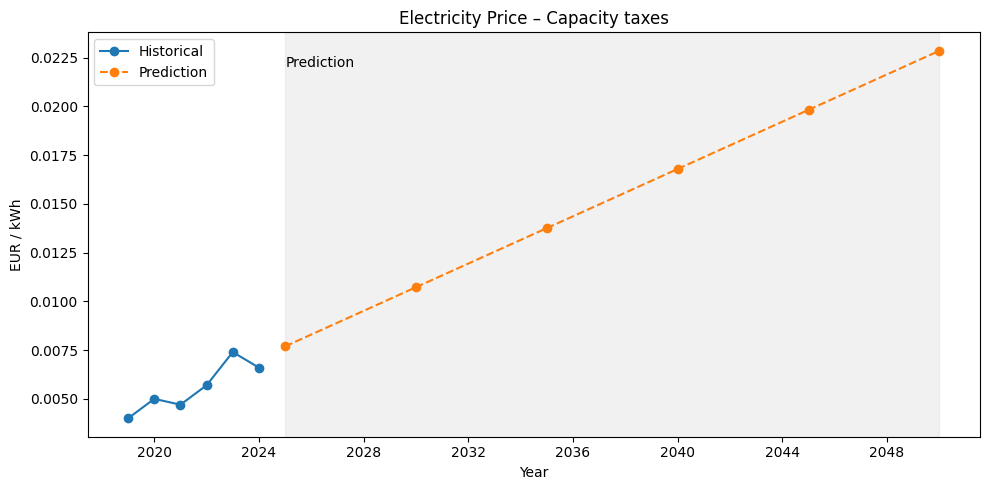

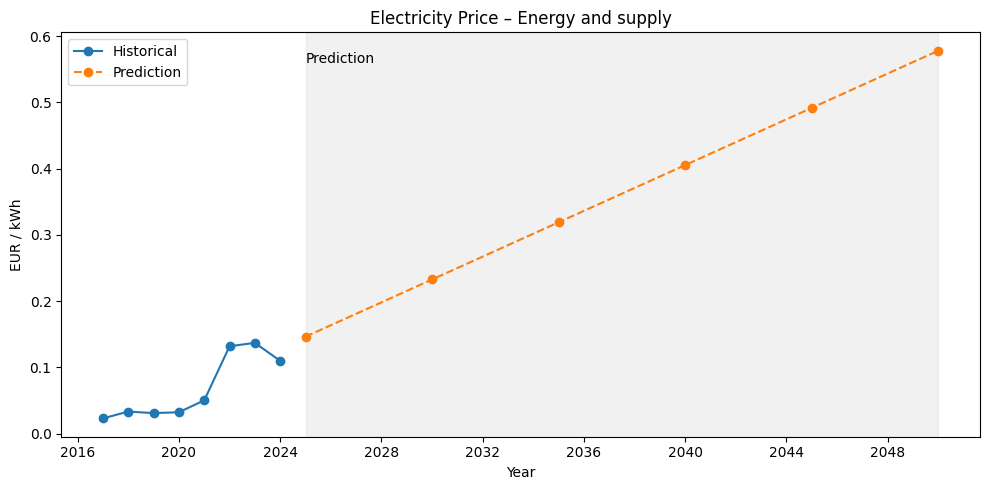

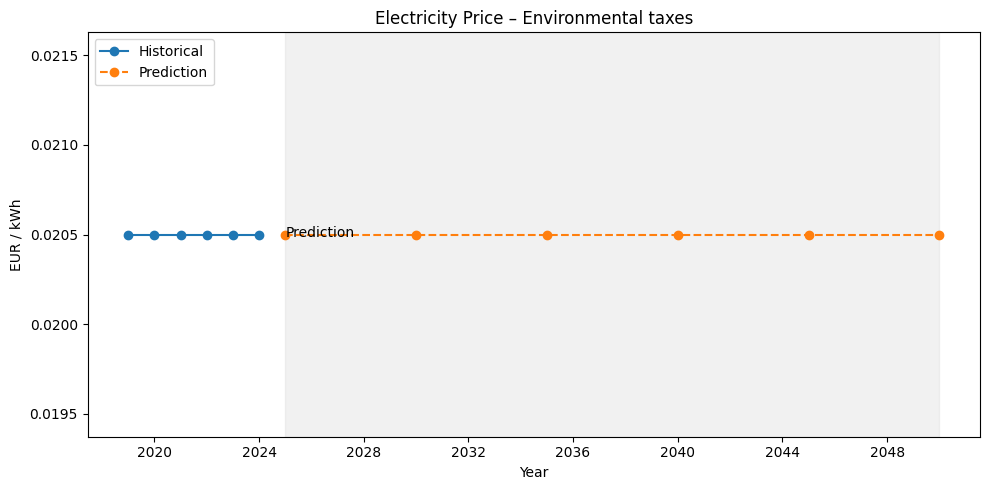

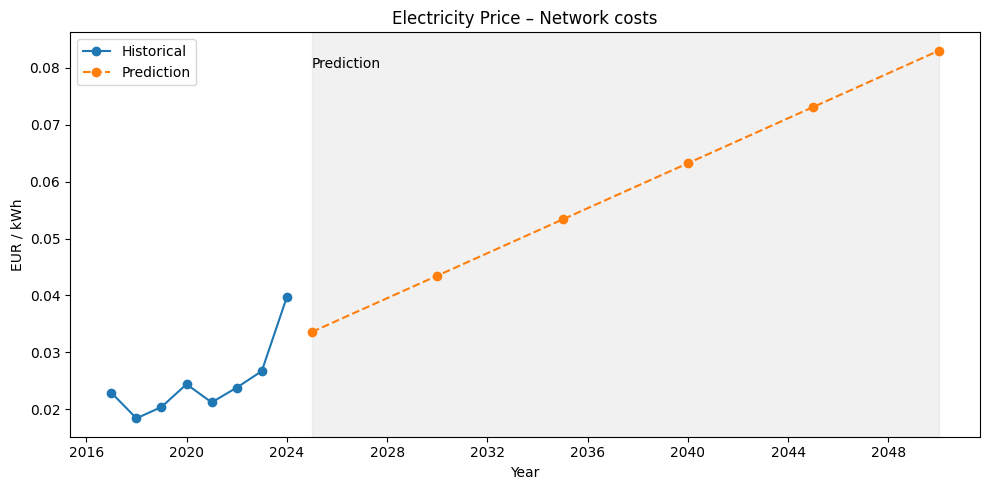

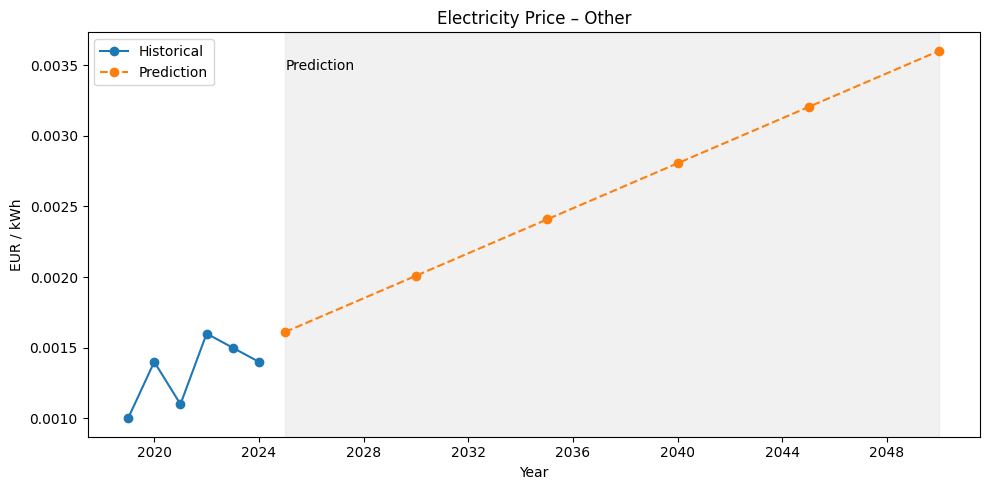

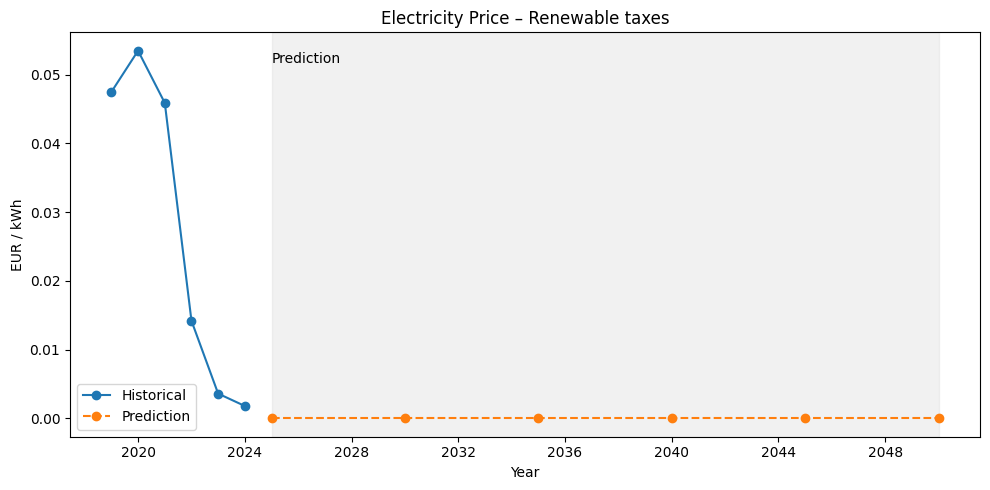

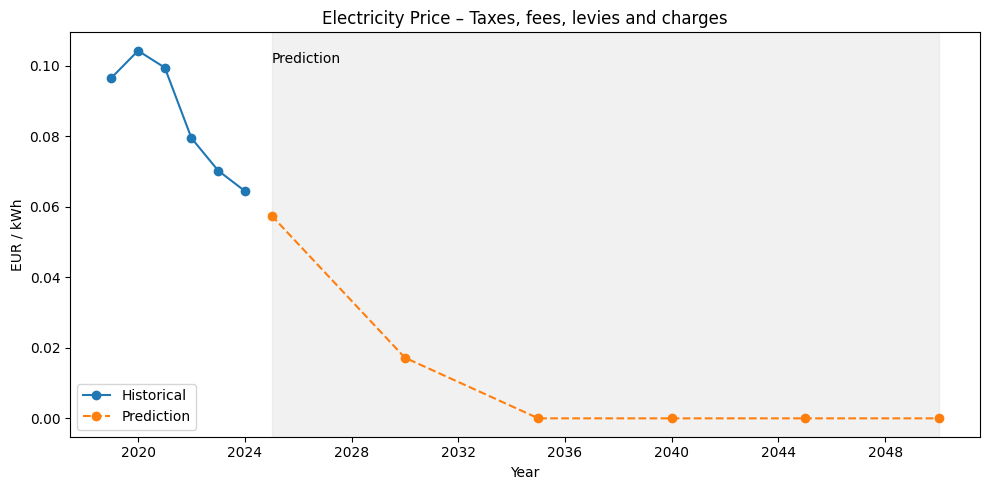

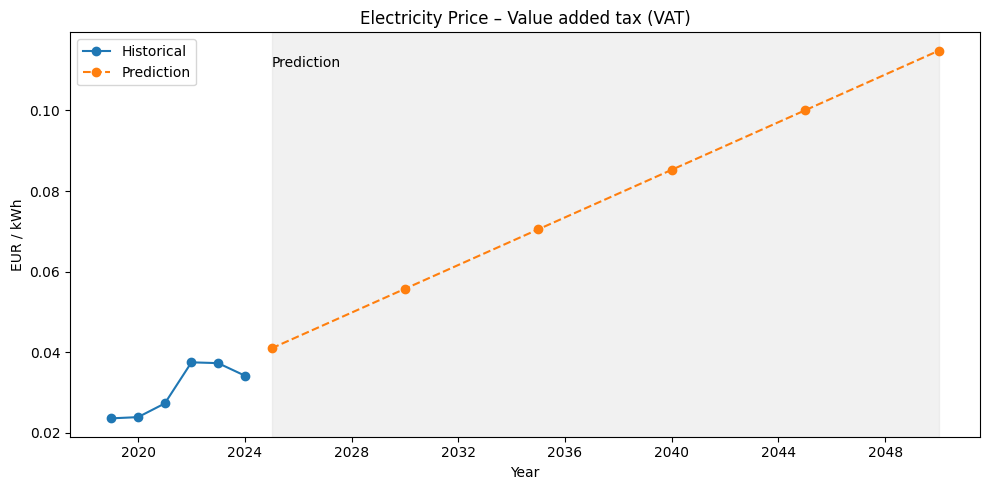

In [101]:
import matplotlib.pyplot as plt

for preisart in df_prices_combined["Preisart"].unique():
    df_sub = df_prices_combined[df_prices_combined["Preisart"] == preisart]

    fig, ax = plt.subplots(figsize=(10, 5))

    # Historisch
    df_hist = df_sub[df_sub["Type"] == "Historical"]
    ax.plot(df_hist["ds"], df_hist["Preis_EUR_kWh"], label="Historical", marker="o", color="#1f77b4")

    # Prognose
    df_prog = df_sub[df_sub["Type"] == "Predicted"]
    ax.plot(df_prog["ds"], df_prog["Preis_EUR_kWh"], label="Prediction", linestyle="--", marker="o", color="#ff7f0e")

    # Schattierung ab Prognosebeginn
    ax.axvspan(pd.to_datetime("2025-01-01"), df_sub["ds"].max(), color="lightgray", alpha=0.3)
    ax.text(pd.to_datetime("2025-01-01"), ax.get_ylim()[1]*0.95, "Prediction", verticalalignment="top")

    ax.set_title(f"Electricity Price – {preisart}")
    ax.set_ylabel("EUR / kWh")
    ax.set_xlabel("Year")
    ax.legend()
    plt.tight_layout()

    filename = f"{preisart.replace(' ', '_').replace('/', '_')}.png"
    fig.savefig(os.path.join(PLOT_OUT_DIR, filename), dpi=300)
    fig.show()


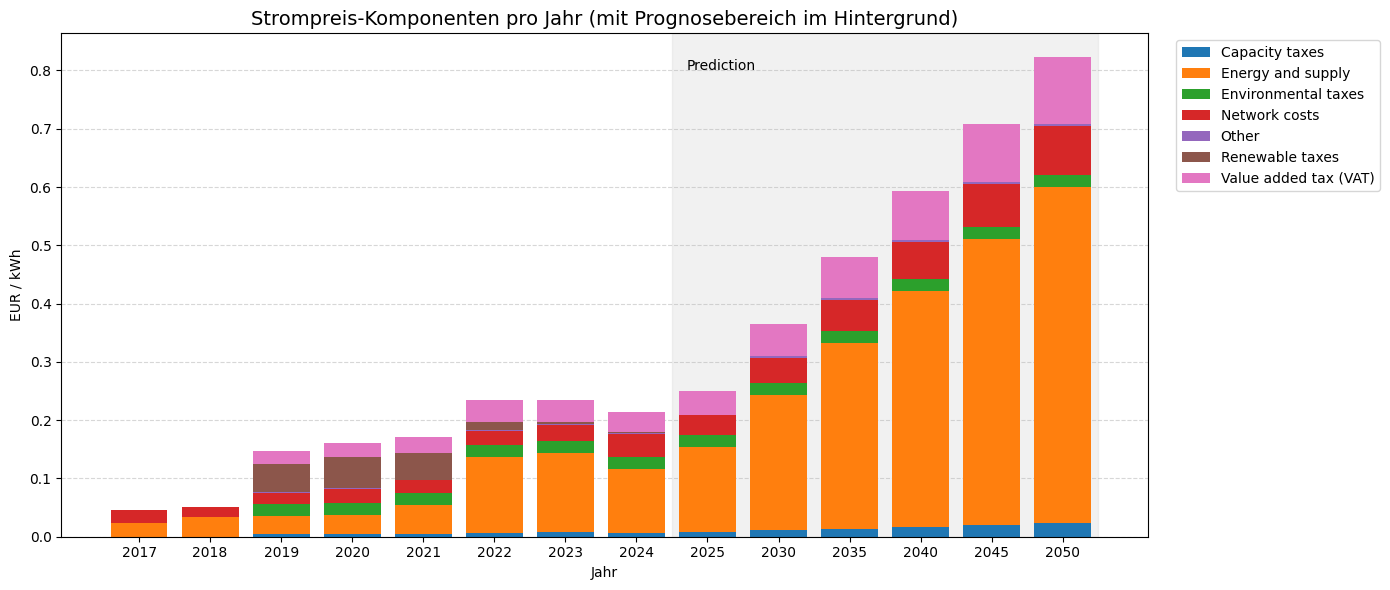

In [102]:
import matplotlib.pyplot as plt

df_plot = df_prices_combined.copy()
df_plot["Jahr"] = df_plot["ds"].dt.year.astype(str)
df_plot = df_plot[df_plot["Preisart"] != "Taxes, fees, levies and charges"]

df_pivot = df_plot.pivot_table(
    index=["Jahr", "Type"],
    columns="Preisart",
    values="Preis_EUR_kWh",
    aggfunc="sum"
).fillna(0).reset_index()

component_cols = df_pivot.columns[2:]
farben = plt.get_cmap("tab10").colors
farbe_map = {name: farben[i % len(farben)] for i, name in enumerate(component_cols)}

df_pivot = df_pivot.sort_values(by=["Type", "Jahr"])
jahre = df_pivot["Jahr"].tolist()

fig, ax = plt.subplots(figsize=(14, 6))

# Hintergrund ab 2025 für predictions
if "2025" in jahre:
    x_start = jahre.index("2025") - 0.5
    x_end = len(jahre) - 0.5
    ax.axvspan(x_start, x_end, color="lightgray", alpha=0.3, zorder=0)  # zorder: ganz hinten
    ax.text(x_start + 0.2, 0.95, "Prediction", transform=ax.get_xaxis_transform(), verticalalignment="top", fontsize=10)

# gestapelte Balken
bottom = [0] * len(df_pivot)
for preisart in component_cols:
    ax.bar(
        jahre,
        df_pivot[preisart],
        bottom=bottom,
        label=preisart,
        color=farbe_map[preisart],
        zorder=2  # Balken über Hintergrund
    )
    bottom = [sum(x) for x in zip(bottom, df_pivot[preisart])]

# Styling
ax.set_title("Strompreis-Komponenten pro Jahr (mit Prognosebereich im Hintergrund)", fontsize=14)
ax.set_ylabel("EUR / kWh")
ax.set_xlabel("Jahr")
ax.grid(True, axis="y", linestyle="--", alpha=0.5, zorder=1)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))
plt.tight_layout()

fig.savefig(os.path.join(PLOT_OUT_DIR, "stacked_price_chart.png"), dpi=300)
plt.show()
